In [3]:
from load_llff import load_llff_data
import numpy as np

images, poses, bds, render_poses, i_test = load_llff_data(
    "/media/hdd/nerf_llff_data/fern",
    8,
    recenter=True,
    bd_factor=0.75,
    spherify=True,
)
hwf = poses[0, :3, -1]
poses = poses[:, :3, :4]
print(
    "Loaded llff",
    images.shape,
    render_poses.shape,
    hwf,
    "/media/hdd/nerf_llff_data/fern",
)
if not isinstance(i_test, list):
    i_test = [i_test]

print("Auto LLFF holdout,", 8)
i_test = np.arange(images.shape[0])[::8]

i_val = i_test
i_train = np.array(
    [i for i in np.arange(int(images.shape[0])) if (i not in i_test and i not in i_val)]
)

print("DEFINING BOUNDS")
if 0:
    near = np.ndarray.min(bds) * 0.9
    far = np.ndarray.max(bds) * 1.0

else:
    near = 0.0
    far = 1.0
print("NEAR FAR", near, far)

Loaded image data (378, 504, 3, 20) [378.         504.         407.56579161]
Loaded /media/hdd/nerf_llff_data/fern 16.985296178676084 80.00209740336334
Data:
(20, 3, 5) (20, 378, 504, 3) (20, 2)
HOLDOUT view is 12
Loaded llff (20, 378, 504, 3) (120, 3, 5) [378.     504.     407.5658] /media/hdd/nerf_llff_data/fern
Auto LLFF holdout, 8
DEFINING BOUNDS
NEAR FAR 0.0 1.0


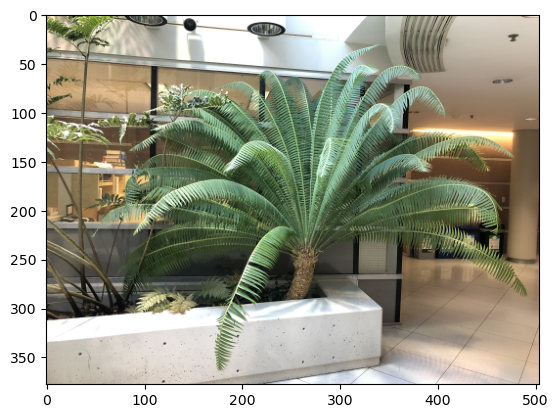

In [5]:
import matplotlib.pyplot as plt

plt.imshow(images[0])

In [12]:
from main import config_parser
from load_llff import load_llff_data
import os
from NeRF_model import *
from NeRF_helper import *

K = None
parser = config_parser()
args = parser.parse_args(args=[])

images, poses, bds, render_poses, i_test = load_llff_data(
    args.datadir,
    args.factor,
    recenter=True,
    bd_factor=0.75,
    spherify=args.spherify,
)
hwf = poses[0, :3, -1]
poses = poses[:, :3, :4]
if not isinstance(i_test, list):
    i_test = [i_test]

if args.llffhold > 0:  # 如果设置了 llffhold 通过每 1/N 张图像作为测试集
    print("Auto LLFF holdout,", args.llffhold)
    i_test = np.arange(images.shape[0])[:: args.llffhold]

i_val = i_test
i_train = np.array(
    [i for i in np.arange(int(images.shape[0])) if (i not in i_test and i not in i_val)]
)
H, W, focal = hwf  # 从 hwf 中提取高度(H),宽度(W)和焦距(focal)
H, W = int(H), int(W)  # 确保高度和宽度是整数类型
hwf = [H, W, focal]  # 重新组合 hwf
# 相机内参
K = np.array([[focal, 0, 0.5 * W], [0, focal, 0.5 * H], [0, 0, 1]])
near = 0.0
far = 1.0
if args.render_test:
    render_poses = np.array(poses[i_test])

# 创建日志目录并复制配置文件
os.makedirs(os.path.join(args.basedir, args.expname), exist_ok=True)  # 创建目录
# 获取位置编码函数
embed_fn, input_ch = get_embedder(args.multires, args.position_encode)
embeddirs_fn, input_ch_views = (
    get_embedder(args.multires_views, args.position_encode)
    if args.use_viewdirs
    else (None, 0)
)
output_ch = 5 if args.N_importance > 0 else 4
# 定义 NeRF 模型
model = NeRF(
    D=args.netdepth,
    W=args.netwidth,
    input_ch=input_ch,
    output_ch=output_ch,
    skips=[4],
    input_ch_views=input_ch_views,
    use_viewdirs=args.use_viewdirs,
).to(args.device)
model_fine = None
if args.N_importance > 0:
    model_fine = NeRF(
        D=args.netdepth_fine,
        W=args.netwidth_fine,
        input_ch=input_ch,
        output_ch=output_ch,
        skips=[4],
        input_ch_views=input_ch_views,
        use_viewdirs=args.use_viewdirs,
    ).to(args.device)
# 定义优化器
model_param = (
    list(model.parameters())
    if model_fine is None
    else list(model.parameters()) + list(model_fine.parameters())
)
model_fn = {
    "network_fn": model,
    "network_fine": model_fine,
    "embed_fn": embed_fn,
    "embeddirs_fn": embeddirs_fn,
    "netchunk": args.netchunk,
}
render_args = {
    "lindisp": args.lindisp,
    "perturb": args.perturb,
    "N_samples": args.N_samples,
    "N_importance": args.N_importance,
    "white_bkgd": args.white_bkgd,
    "raw_noise_std": args.raw_noise_std,
    "pytest": False,
}
start = 0
# 加载预训练模型
if args.ft_path is not None:
    if os.path.isfile(args.ft_path):
        ckpt_path = args.ft_path
    elif os.path.isdir(args.ft_path):
        ckpt_path = sorted(glob.glob(os.path.join(args.ft_path, "*.tar")))[-1]
    ckpt = torch.load(ckpt_path)
    start = ckpt["global_step"]
    model_fn["network_fn"].load_state_dict(ckpt["network_fn_state_dict"])
    if model_fn["network_fine"] is not None:
        model_fn["network_fine"].load_state_dict(ckpt["network_fine_state_dict"])
    print("Loaded checkpoint from", ckpt_path)
rays = np.stack([get_rays_np(H, W, K, p) for p in poses], 0)  # [N, ro+rd, H, W, 3]
rgb, disp, acc, extras = render(
    H=H,
    W=W,
    K=K,
    near=near,
    far=far,
    chunk=args.chunk,
    rays=rays,
    model_fn=model_fn,
    render_args=render_args,
    use_viewdirs=args.use_viewdirs,
)

Loaded image data (378, 504, 3, 20) [378.         504.         407.56579161]
Loaded /media/hdd/nerf_llff_data/fern 16.985296178676084 80.00209740336334
recentered (3, 5)
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  1.4901161e-09]
 [ 0.0000000e+00  1.0000000e+00 -1.8730975e-09 -9.6857544e-09]
 [-0.0000000e+00  1.8730975e-09  1.0000000e+00  0.0000000e+00]]
Data:
(20, 3, 5) (20, 378, 504, 3) (20, 2)
HOLDOUT view is 12
Auto LLFF holdout, 8
Loaded checkpoint from ./logs/test/008000.ckpt


ValueError: too many values to unpack (expected 2)

In [13]:
rays.shape

(20, 2, 378, 504, 3)